In [1]:
# prepare dataset
import os
import re
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy

file = './data/10334-1.csv'

def bin_array(arr, bin_edges):
    '''Function for binning data'''
    bin_indices = np.digitize(arr, bin_edges, right=False)
    return bin_edges[bin_indices-1]

bins_5 = [18]+list(np.arange(25,90,5))+[1000] # bin edges for mostly 5-year intervals
bins_10 = [18]+list(np.arange(30,90,10))+[1000] # bin edges for mostly 10-year intervals
bins_5 = np.array(bins_5)
bins_10 = np.array(bins_10)

def remove_outliers(x):
    '''Function for removing outliers from skewed data using Tukey's method after Box-Cox transform'''
    x, _ = scipy.stats.boxcox(x) # normalize distribution shape
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3-q1
    idx = x<(q3+(1.5*iqr))
    return idx

def prepare_data(filepath,
                 dropdup = 1,
                 dropna = 1,
                 remove_outlier = 1):
    
    # read data
    df = pd.read_csv(filepath)
    
    # only female gender
    df = df[df['gender']=='F']
    df = df[df.unit=='u/ml'] # ensure correct units (makes no difference as seen below)
    df = df[df['age']>=18] # age at least 18 following other studies
    
    # ensure float value
    df.value = np.array(df.value).astype(float)
    
    # preprocess
    if dropdup: # select most recent record per patient
        df['date'] = pd.to_datetime(df.date)
        df = df.sort_values(by='date', ascending=True)
        df = df.drop_duplicates(subset='id', keep='last') # remove multiple patient records
    if dropna: # drop NAs
        df = df.dropna(inplace=False, subset='value')
    if remove_outlier: # remove outliers
        pts_before_or = len(df)
        idx = remove_outliers(df.value.values)
        df = df[idx]
        print('Filtered out: '+str(1-len(df)/pts_before_or))
   
    return df


### Check Outliers

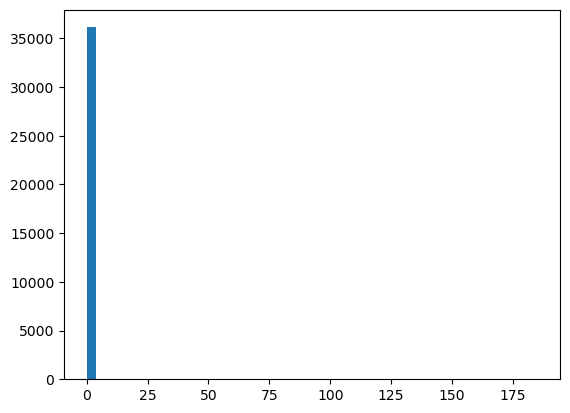

In [2]:
# check outliers
df = prepare_data(file, dropdup=1, dropna=1, remove_outlier=0)
data = df.value.values
data = (data-data.mean())/data.std()
import matplotlib.pyplot as plt
plt.hist(data, 50);


### % points >10 std from mean

In [3]:
len(np.where(data>10)[0])/len(data)


8.294166436273154e-05

### Check units

In [4]:
# check units
df = pd.read_csv(file)
for i in list(set(df.unit)):
    print(str(i)+'\t'+str(len(df[df.unit==i])))
    

ml	3
nan	0
u/ml	48440


### Check % Males

In [5]:
# males
len(df[df.gender=='M'])/len(df)


0.028001154686791208

In [6]:
del data


### Get preprocessed data

In [7]:
# official data for analysis
df = prepare_data(file, remove_outlier=1)


Filtered out: 0.015427149571468068


### Count unique patients


In [8]:
# no.unique patients
len(set(df.id))


35612

### Check age-dependent data distributions

In [9]:
# get binned ages
binned_age = bin_array(df['age'], bins_10)


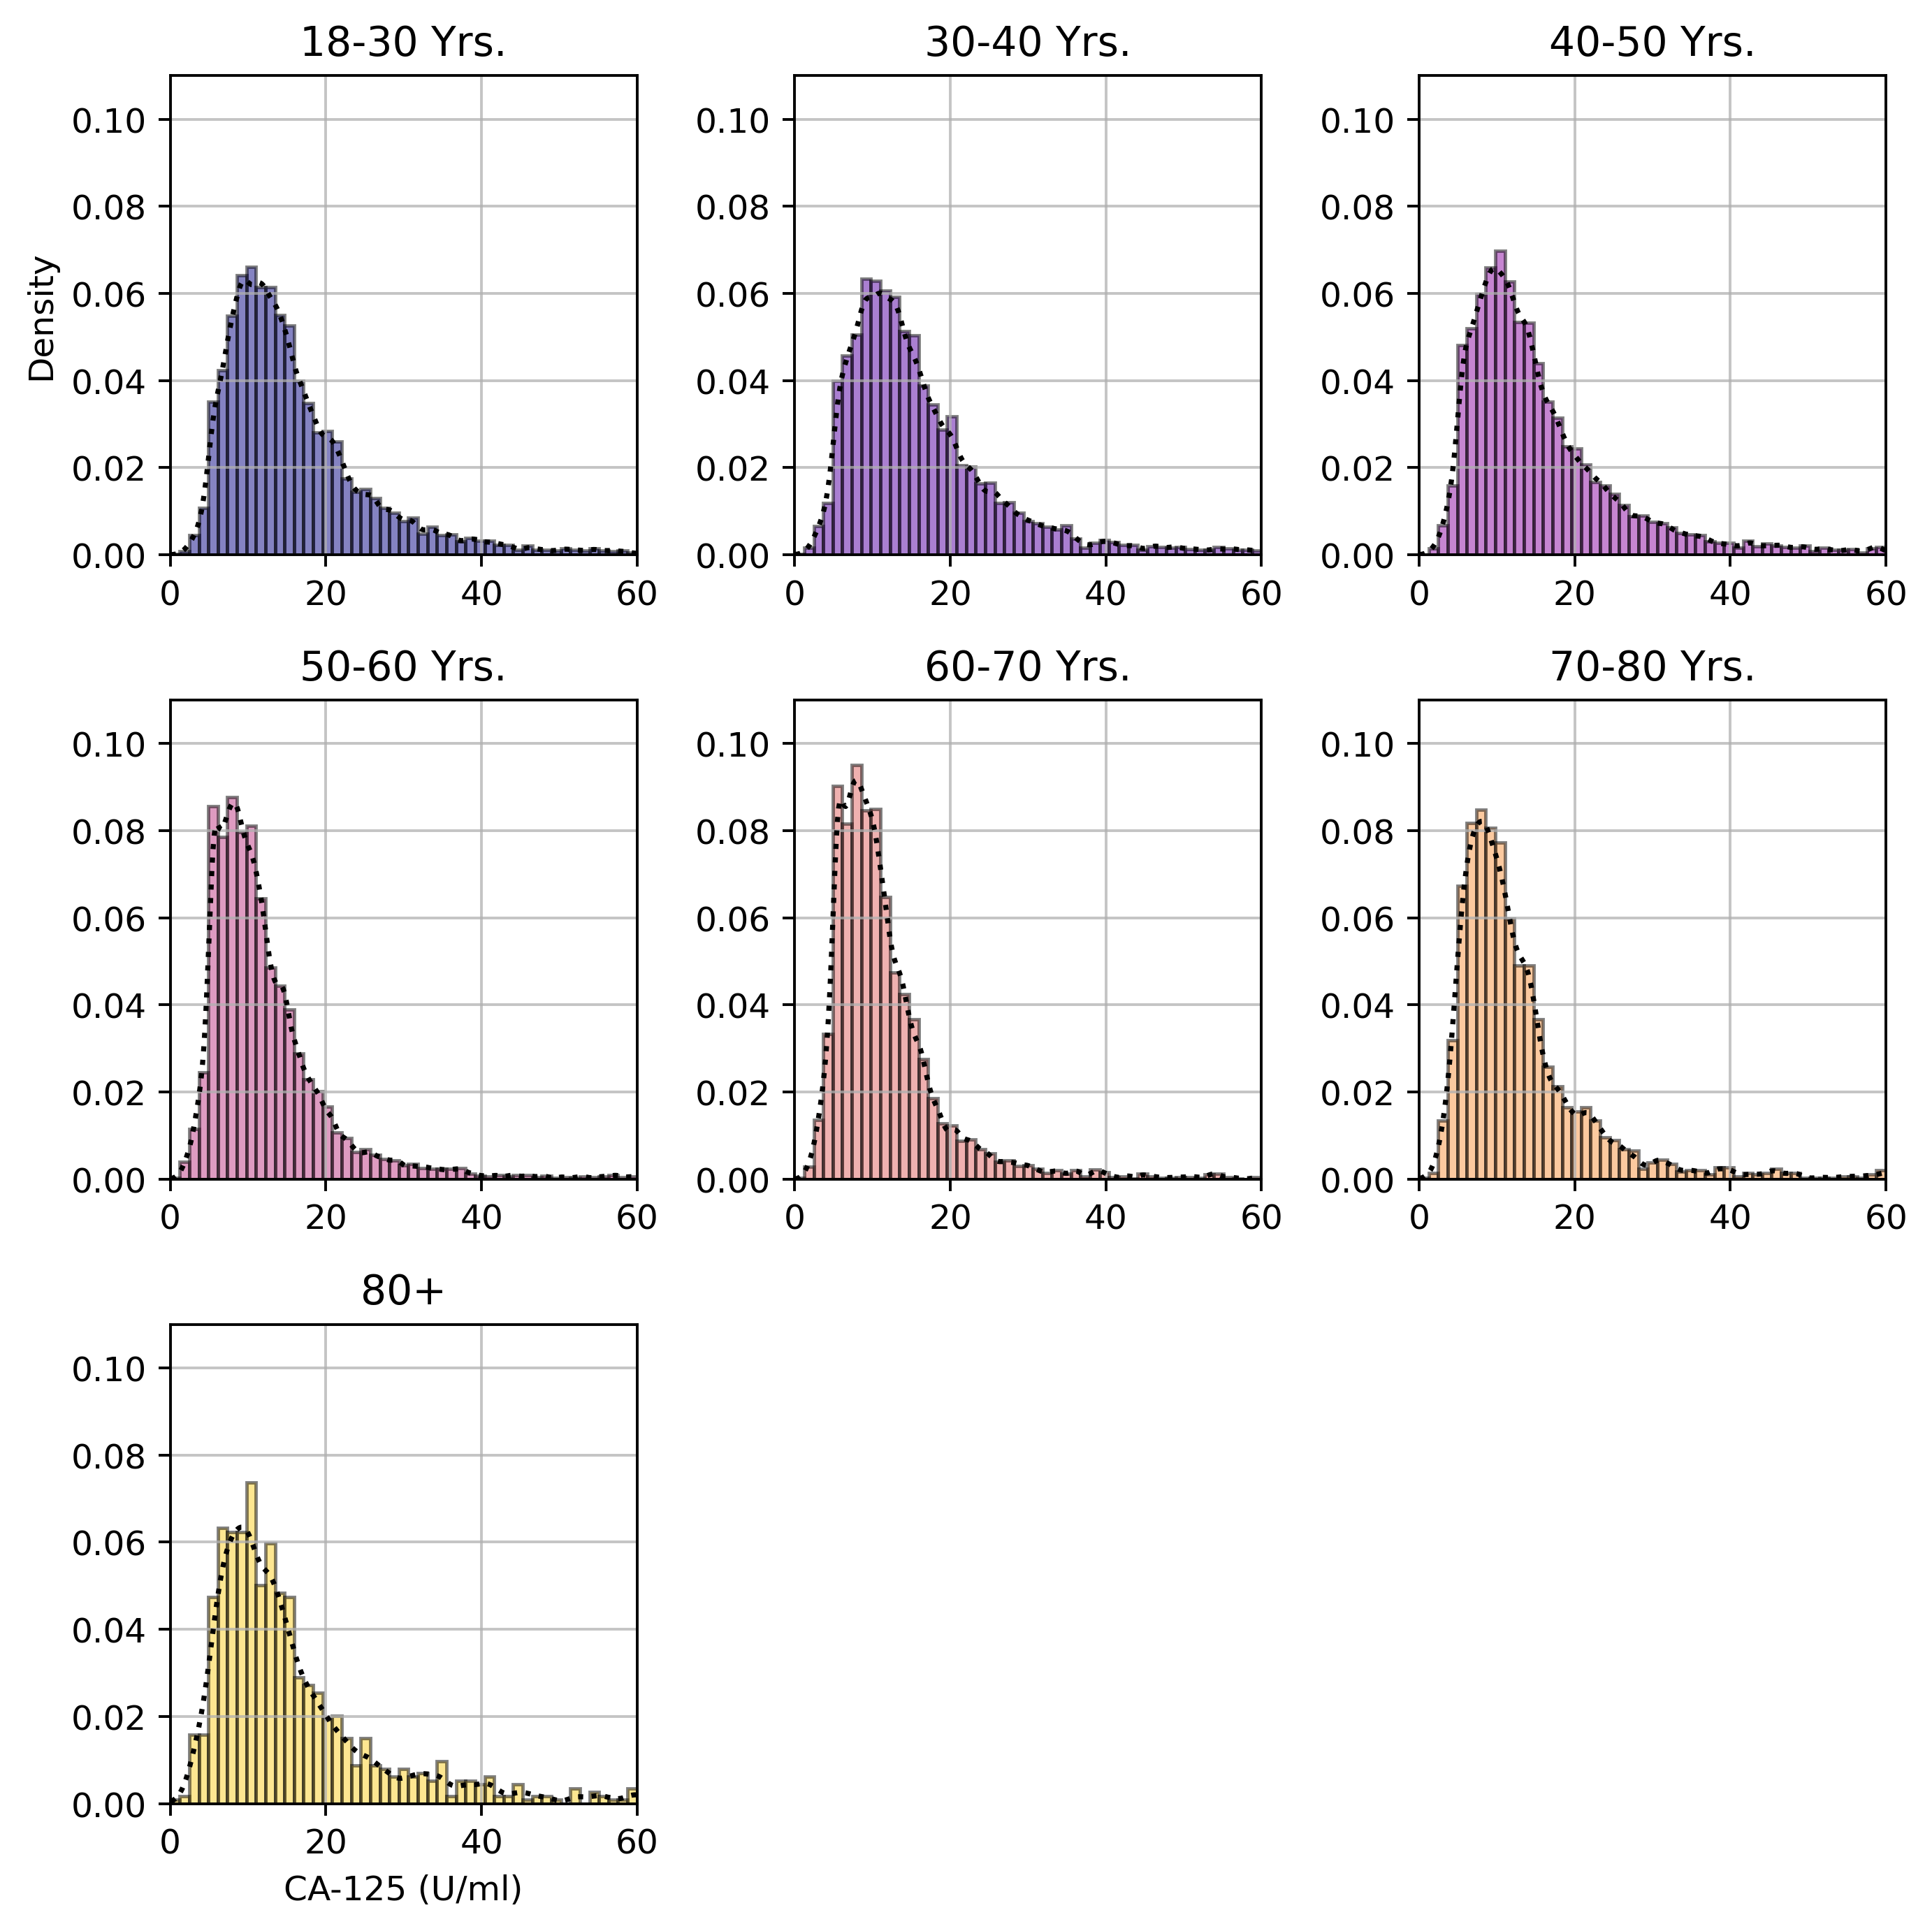

In [10]:
colormap = mpl.colormaps['plasma']  # Replace 'viridis' with the desired colormap
colors = colormap(np.linspace(0, 0.9, len(set(binned_age))))

plt.figure(figsize=(8,8), dpi=350)
kde_bandwidth = 0.05
x_range = np.linspace(0.1, 300, 2000)
for c,i in enumerate(bins_10[:-1]):
    if i==90:
        continue
    plt.subplot(3,3,c+1)
    if c==0:
        plt.ylabel('Density')
    if c==6:
        plt.xlabel('CA-125 (U/ml)')
    if i!=80:
        sample = df.value[binned_age==i].values
        sample = sample[sample<=200]
    else:
        sample = df.value[binned_age>=i].values
        sample = sample[sample<=200]
    plt.hist(sample, np.linspace(0, 60, 50), density=True, color=colors[c], edgecolor='k', alpha=0.5)
    
    kde = scipy.stats.gaussian_kde(sample, bw_method=kde_bandwidth)
    pdf = kde(x_range)
    plt.plot(x_range, pdf, color='k', linestyle=':')
    
    if i!=80:
        plt.title(str(i)+'-'+str(bins_10[c+1])+' Yrs.')
    else:
        plt.title(str(i)+'+')

    plt.grid(alpha=0.75);
    plt.ylim([0, 0.11])
    plt.xlim([0, 60]);
    plt.tight_layout()

# plt.legend(title='Age');
# plt.gcf().set_facecolor('white')
# plt.grid();
# plt.ylabel('Density')
# plt.xlabel('CA-125 (U/ml)')
# plt.xlim([0, 50]);
# plt.gca().set_yticks([]);
# plt.title('Age-specific CA-125 Distributions');


3.5495943733254163
3.264939680597864
3.38853656802982
4.87006685349129
5.421845596773768
4.260453891600276
3.1606451940412237


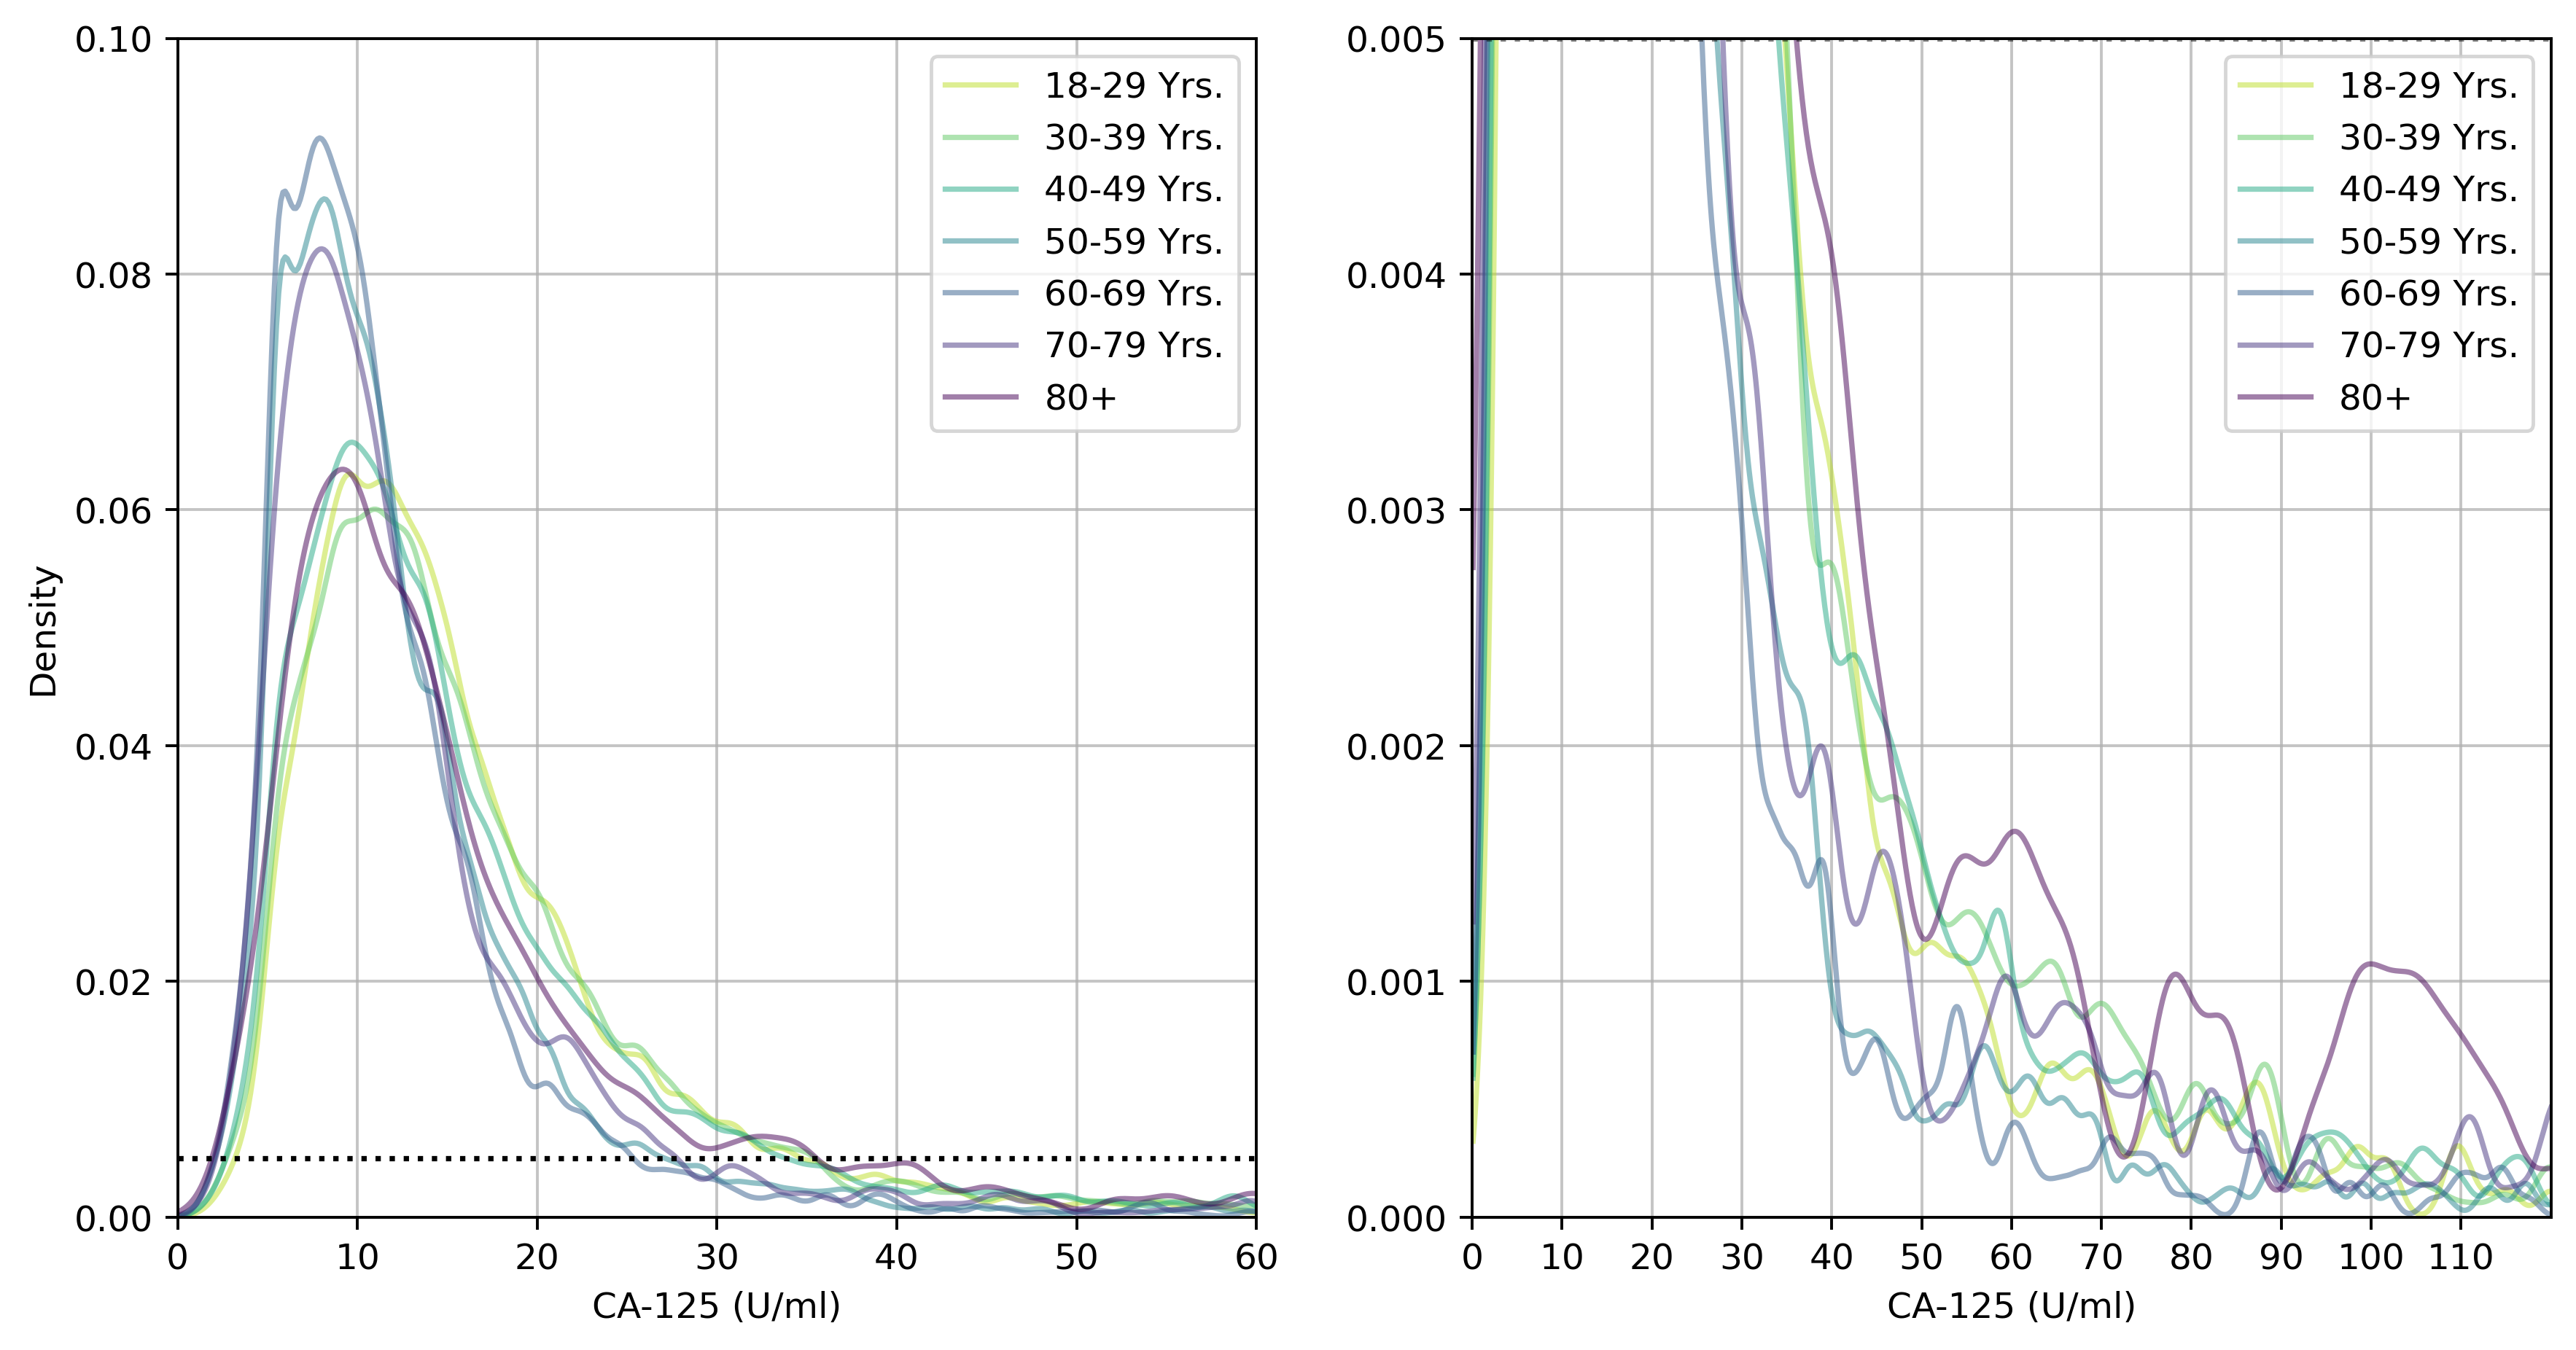

In [11]:
# age_bin_size = 20
# binned_age = bin_array(df['age_group_start'], age_bin_size).astype(int)

colormap = mpl.colormaps['viridis']  # Replace 'viridis' with the desired colormap
colors = colormap(np.linspace(0.9, 0, len(set(binned_age))))

plt.figure(figsize=(12,6), dpi=350)
x_range = np.linspace(0.1, 120, 1000)
kde_bandwidth = 0.05
plt.subplot(1,2,1)
for c,i in enumerate(bins_10[:-1]):
    plt.ylabel('Density')
    plt.xlabel('CA-125 (U/ml)')
    if i!=80:
        sample = df.value[binned_age==i]
        print(scipy.stats.skew(sample))
        sample = sample[sample<=200]
    else:
        sample = df.value[binned_age>=i]
        print(scipy.stats.skew(sample))
        sample = sample[sample<=200]        
    if i!=80:
        label = str(i)+'-'+str(bins_10[c+1]-1)+' Yrs.'
    else:
        label = str(i)+'+'
    kde = scipy.stats.gaussian_kde(sample, bw_method=kde_bandwidth)
    pdf = kde(x_range)
    plt.plot(x_range, pdf, color=colors[c], alpha=0.5, label=label)
plt.grid(alpha=0.75);
plt.xlim([0, 60])
plt.ylim([0, 0.1]);
plt.axhline(0.005, c='k', linestyle=':')
plt.legend();

kde_bandwidth = 0.1
plt.subplot(1,2,2)
for c,i in enumerate(bins_10[:-1]):
    plt.xlabel('CA-125 (U/ml)')
    if i!=80:
        sample = df.value[binned_age==i]
        sample = sample[sample<=200]
    else:
        sample = df.value[binned_age>=i]
        sample = sample[sample<=200]        
    if i!=80:
        label = str(i)+'-'+str(bins_10[c+1]-1)+' Yrs.'
    else:
        label = str(i)+'+'
    kde = scipy.stats.gaussian_kde(sample, bw_method=kde_bandwidth)
    pdf = kde(x_range)
    plt.plot(x_range, pdf, color=colors[c], alpha=0.5, label=label)
plt.xticks(np.arange(0, 120, 10))
plt.grid(alpha=0.75);
plt.xlim([0, 120])
plt.ylim([0, 0.005]);
plt.axhline(0.005, alpha=0.5, c='k', linestyle=':')
plt.legend();


### Get dataset summary statistics

In [12]:
np.mean(df.value)


15.74626726945973

In [13]:
np.median(df.value)


12.0

In [14]:
np.quantile(df.value, 0.1)


6.0

In [15]:
np.quantile(df.value, 0.90)


27.5

In [16]:
max(df.value)


141.0

In [17]:
min(df.value)


0.6

In [18]:
scipy.stats.skew(df.value)


3.869474275550235

### Plot points per year

In [19]:
# number of points per year
for i in sorted(list(set(df.year))):
    print(i, '\t', len(df[df.year==i]))

2018 	 4944
2019 	 8357
2020 	 5713
2021 	 5247
2022 	 4916
2023 	 6435


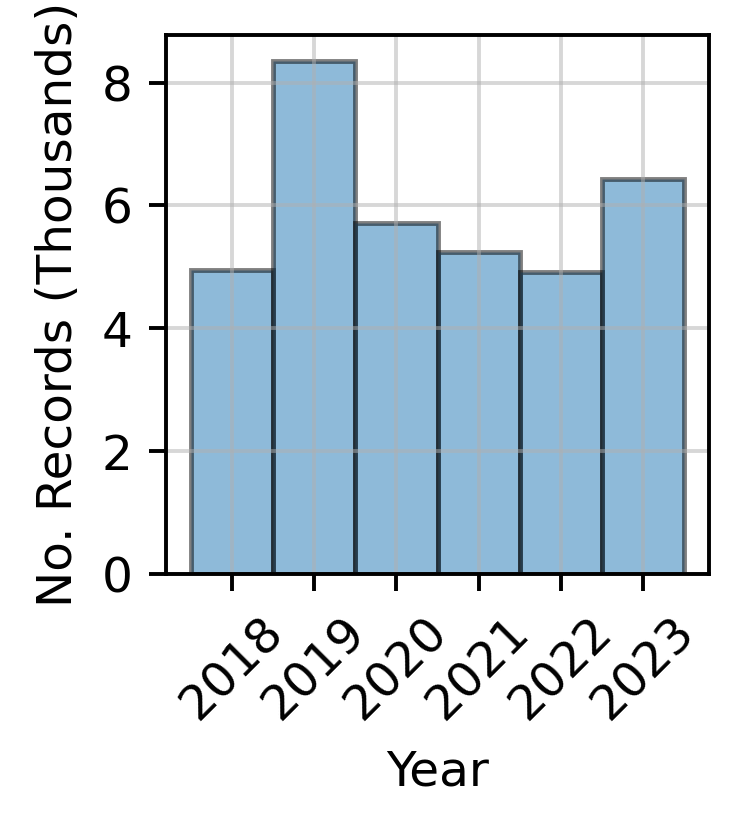

In [20]:
plt.figure(figsize=(2, 2), dpi=350)
plt.bar(
    sorted(list(set(df.year))), 
    [len(df[df.year==i])/1000 for i in sorted(list(set(df.year)))],
    width=1,
    edgecolor='k',
    alpha=0.5
)
plt.xlabel('Year')
plt.xticks(sorted(list(set(df.year))), rotation=45)
plt.gca().set_xticklabels(sorted(list(set(df.year))))
plt.ylabel('No. Records (Thousands)');
plt.grid(alpha=0.5);


### Plot points per age group

In [21]:
# get binned ages at mostly 5 years
binned_age = bin_array(df['age'], bins_5)


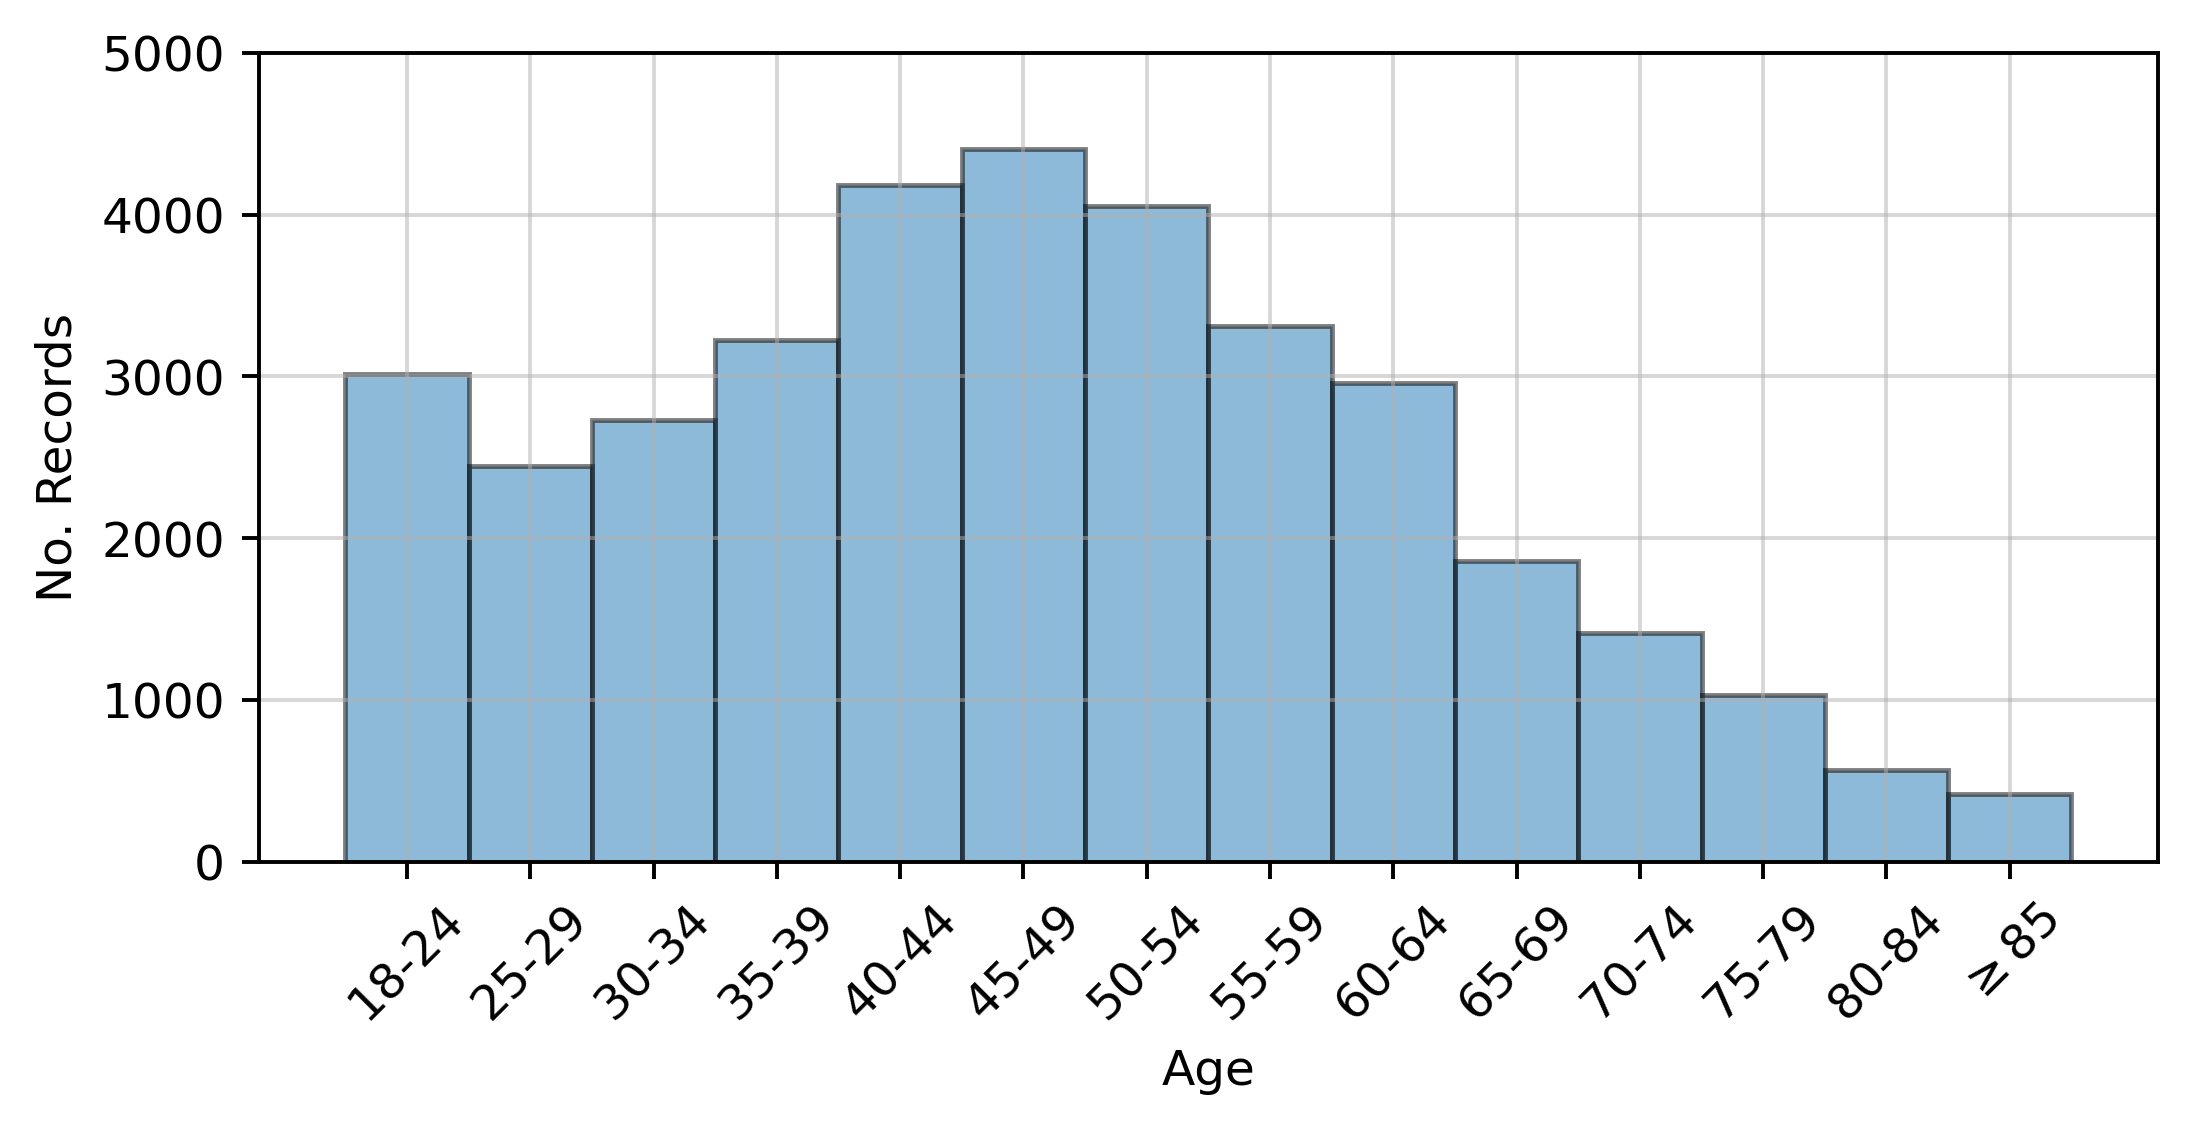

In [22]:
plt.figure(figsize=(7, 3), dpi=350)
x = bins_5[:-1]
y = [len(np.where(binned_age==i)[0]) for i in bins_5[:-1]]
plt.bar(
    np.arange(len(bins_5)-1), 
    y,
    width=1,
    edgecolor='k',
    alpha=0.5
)
plt.xlabel('Age')
plt.xticks(np.arange(len(bins_5)-1));
plt.gca().set_xticklabels([str(bins_5[i])+'-'+str(bins_5[i+1]-1) if bins_5[i]<85 else r'$\geq85$' for i in range(len(bins_5)-1)], rotation=45);
plt.ylabel('No. Records');
plt.grid(alpha=0.5);
plt.ylim([0, 5000]);


In [23]:
outpath = './data/age_binned/'
if os.path.exists(outpath):
    shutil.rmtree(outpath)
    os.mkdir(outpath)
else:
    os.mkdir(outpath)
    
for i in bins_5[:-1]:
    df[binned_age==i].to_csv(outpath+'data_'+str(i)+'.csv')
    

In [24]:
scipy.__version__


'1.12.0'

In [25]:
# saving preprocessed data
df.to_csv('./preprocessed_data.csv')


In [26]:
# testing refineR without outlier removal
df = prepare_data(file, remove_outlier=0)
binned_age = bin_array(df['age'], bins_5)
outpath = './data/age_binned_no_outlier_removal/'
if os.path.exists(outpath):
    shutil.rmtree(outpath)
    os.mkdir(outpath)
else:
    os.mkdir(outpath)
    
for i in bins_5[:-1]:
    df[binned_age==i].to_csv(outpath+'data_'+str(i)+'.csv')
    

In [27]:
# saving preprocessed data
df.to_csv('./preprocessed_data_no_outlier_removal.csv')


In [28]:
scipy.stats.skew(df.value.values)


175.6616122759285